In [12]:
from pathlib import Path
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.mixture import BayesianGaussianMixture
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import IsolationForest
from umap import UMAP
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import hdbscan
from datetime import datetime

In [13]:
!pwd

/Users/adityabehal/Documents/RPI/Junior/Summer/UCSF/Shirvalkar-Lab/clustering


In [14]:
pt_id = "RCS06"

In [15]:
IMAGES_PATH = Path() / "data" / pt_id
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [16]:
pt_pain_path = Path() / "data" / pt_id / (pt_id + "_pain_filtered.xlsx")
pt_sleep_path = Path() / "data" / pt_id / (pt_id + "_sleepStageLogInfo_20190130_20230530.csv")
pt_wear_path = Path() / "data" / pt_id / (pt_id + "_fitbitWearTimeViaHR_20190130_20230530.csv")

pt_pain = pd.read_excel(pt_pain_path)
pt_sleep = pd.read_csv(pt_sleep_path)
pt_wear = pd.read_csv(pt_wear_path)

In [17]:
# convert a StartTime to a relative start time (see the cell below)
def convert_to_fractional_time(time_string):
    time_parts = time_string.split(' ')[-2].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    am_pm = time_string.split(' ')[-1].strip().upper()

    if am_pm == 'PM' and hours != 12:
        hours += 12
    elif am_pm == 'AM' and hours == 12:
        hours = 0

    fractional_hours = hours + (minutes / 60.0) + (seconds / 3600.0)

    if fractional_hours >= 24:
        fractional_hours -= 24

    return fractional_hours

In [18]:
# extract just the Day from the StartTime field and store it in a separate column
pt_sleep["Day"] = pt_sleep["StartTime"].str.split().str[0]

# binarize SleepDataType --> classic = 0, stages = 1
pt_sleep["SleepDTBinary"] = LabelEncoder().fit_transform(pt_sleep["SleepDataType"])

# we'll also convert times in StartTime to relative start times 
# (i.e. ignore the day and just look at the HH:MM:SS AM/PM and convert it into a number ranging from 0 - 24 hours)
pt_sleep["RelativeStartTime"] = pt_sleep["StartTime"].apply(convert_to_fractional_time)

# get rid of days with 0 perrcent wear time
pt_wear = pt_wear[pt_wear["PercentageWearTime"] != 0]

# merge sleep and wear dataframes with SQL-like inner join
pt_sleep_wear = pd.merge(pt_sleep, pt_wear, on="Day", how="inner")

# shorten some column names to improve plotting aesthetics 
pt_sleep_wear.columns = pt_sleep_wear.columns.str.replace("Classic", "C-")
pt_sleep_wear.columns = pt_sleep_wear.columns.str.replace("Stages", "S-")

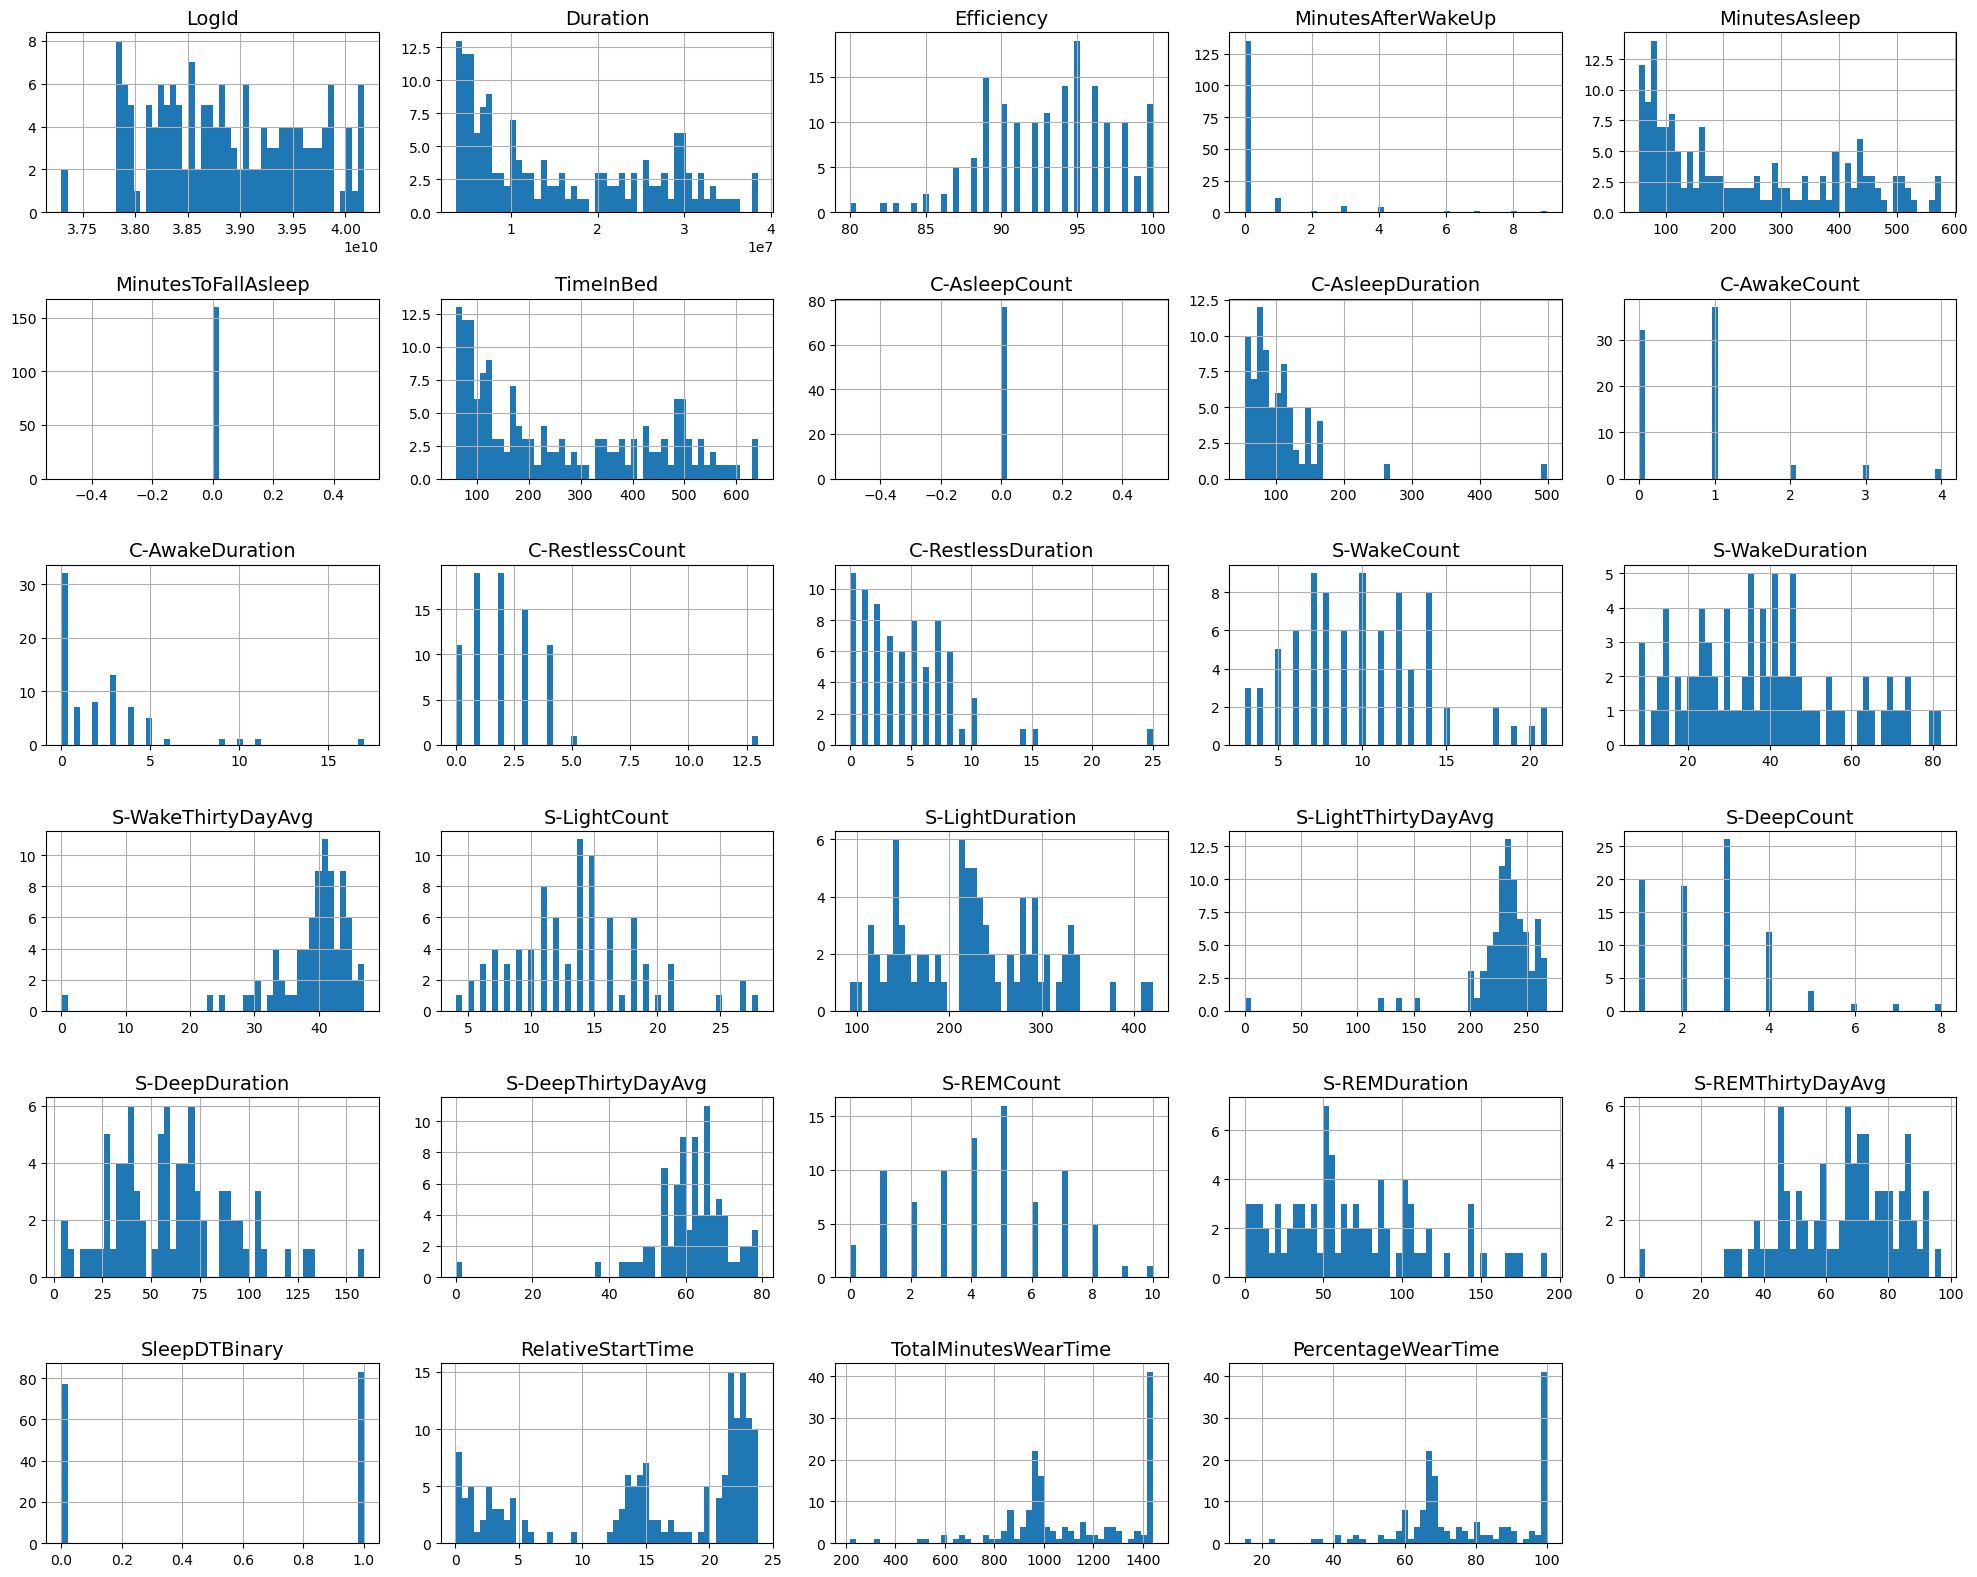

In [19]:
# the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# let's get histograms of the data variables
pt_sleep_wear.hist(bins=50, figsize=(20, 16))
plt.tight_layout()
save_fig((pt_id + "_sleep_histogram_plots"))
plt.show()

In [20]:
# let's get a sense of the number and data types of the dataframe columns
pt_sleep_wear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 159
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LogId                 160 non-null    int64  
 1   StartTime             160 non-null    object 
 2   Duration              160 non-null    int64  
 3   Efficiency            160 non-null    int64  
 4   IsMainSleep           160 non-null    bool   
 5   SleepDataType         160 non-null    object 
 6   MinutesAfterWakeUp    160 non-null    int64  
 7   MinutesAsleep         160 non-null    int64  
 8   MinutesToFallAsleep   160 non-null    int64  
 9   TimeInBed             160 non-null    int64  
 10  C-AsleepCount         77 non-null     float64
 11  C-AsleepDuration      77 non-null     float64
 12  C-AwakeCount          77 non-null     float64
 13  C-AwakeDuration       77 non-null     float64
 14  C-RestlessCount       77 non-null     float64
 15  C-RestlessDuration    7

In [21]:
# we'll consider data as reliable if the wear time for that day was more than 80 percent and if it was auto-detected
pt_sleep_wear = pt_sleep_wear[pt_sleep_wear["PercentageWearTime"] >= 80]
pt_sleep_wear = pt_sleep_wear[pt_sleep_wear["SleepLogType"] == "auto_detected"]

In [22]:
# let's get a sense of our filtered data by looking at the first 5 rows
pt_sleep_wear.head()

LogId             StartTime  Duration  Efficiency  IsMainSleep  \
38  38308621630   9/8/2022 9:59:30 PM   6480000          96        False   
41  38333763342  9/11/2022 9:13:00 AM   5280000          93        False   
42  38335882750  9/11/2022 2:36:00 PM   4500000          87        False   
43  38338374515  9/11/2022 8:45:00 PM  38520000          87         True   
44  38350832667  9/12/2022 7:34:00 PM  16560000          83         True   

   SleepDataType  MinutesAfterWakeUp  MinutesAsleep  MinutesToFallAsleep  \
38       classic                   3            101                    0   
41       classic                   0             82                    0   
42       classic                   0             65                    0   
43        stages                   0            577                    0   
44        stages                   9            232                    0   

    TimeInBed  ...  S-DeepThirtyDayAvg  S-REMCount  S-REMDuration  \
38        108  ...                 NaN         NaN            NaN   
41         88  ...                 NaN         NaN            NaN   
42         75  ...                 NaN         NaN            NaN   
43        642  ...                78.0         7.0          192.0   
44        276  ...                79.0         2.0           36.0   

    S-REMThirtyDayAvg   SleepLogType        Day  SleepDTBinary  \
38                NaN  auto_detected   9/8/2022              0   
41                NaN  auto_detected  9/11/2022              0   
42                NaN  auto_detected  9/11/2022              0   
43               86.0  auto_detected  9/11/2022              1   
44               97.0  auto_detected  9/12/2022              1   

    RelativeStartTime  TotalMinutesWearTime  PercentageWearTime  
38          21.991667                  1423           98.819444  
41           9.216667                  1429           99.236111  
42          14.600000                  1429           99.236111  
43          20.750000                  1429           99.236111  
44          19.566667                  1440          100.000000  

[5 rows x 34 columns]

In [23]:
# let's get a sense of the number and data types of the filtered dataframe columns
pt_sleep_wear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 38 to 155
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LogId                 50 non-null     int64  
 1   StartTime             50 non-null     object 
 2   Duration              50 non-null     int64  
 3   Efficiency            50 non-null     int64  
 4   IsMainSleep           50 non-null     bool   
 5   SleepDataType         50 non-null     object 
 6   MinutesAfterWakeUp    50 non-null     int64  
 7   MinutesAsleep         50 non-null     int64  
 8   MinutesToFallAsleep   50 non-null     int64  
 9   TimeInBed             50 non-null     int64  
 10  C-AsleepCount         20 non-null     float64
 11  C-AsleepDuration      20 non-null     float64
 12  C-AwakeCount          20 non-null     float64
 13  C-AwakeDuration       20 non-null     float64
 14  C-RestlessCount       20 non-null     float64
 15  C-RestlessDuration    2

In [24]:
# let's get summary statistics of the filtered dataframe columns
pt_sleep_wear.describe()

LogId      Duration  Efficiency  MinutesAfterWakeUp  \
count  5.000000e+01  5.000000e+01   50.000000           50.000000   
mean   3.903532e+10  1.679280e+07   93.160000            0.480000   
std    5.614782e+08  1.035291e+07    4.330056            1.541799   
min    3.830862e+10  3.660000e+06   83.000000            0.000000   
25%    3.861316e+10  6.645000e+06   90.000000            0.000000   
50%    3.882914e+10  1.482000e+07   93.500000            0.000000   
75%    3.951031e+10  2.517000e+07   96.000000            0.000000   
max    4.012630e+10  3.852000e+07  100.000000            9.000000   

       MinutesAsleep  MinutesToFallAsleep   TimeInBed  C-AsleepCount  \
count      50.000000                 50.0   50.000000           20.0   
mean      253.660000                  0.0  279.880000            0.0   
std       155.007388                  0.0  172.548442            0.0   
min        61.000000                  0.0   61.000000            0.0   
25%       103.000000                  0.0  110.750000            0.0   
50%       217.000000                  0.0  247.000000            0.0   
75%       379.500000                  0.0  419.500000            0.0   
max       577.000000                  0.0  642.000000            0.0   

       C-AsleepDuration  C-AwakeCount  ...  S-DeepCount  S-DeepDuration  \
count         20.000000      20.00000  ...    30.000000       30.000000   
mean          99.250000       0.65000  ...     2.700000       65.900000   
std           30.647186       0.74516  ...     1.149213       27.916563   
min           61.000000       0.00000  ...     1.000000       15.000000   
25%           76.500000       0.00000  ...     2.000000       54.500000   
50%           89.000000       1.00000  ...     3.000000       67.000000   
75%          116.750000       1.00000  ...     3.000000       76.500000   
max          161.000000       3.00000  ...     5.000000      131.000000   

       S-DeepThirtyDayAvg  S-REMCount  S-REMDuration  S-REMThirtyDayAvg  \
count           30.000000   30.000000      30.000000          30.000000   
mean            62.566667    4.300000      73.133333          73.966667   
std              6.891691    2.036732      46.432549          13.852632   
min             54.000000    0.000000       0.000000          43.000000   
25%             58.000000    3.000000      38.250000          66.250000   
50%             61.000000    4.500000      71.500000          77.000000   
75%             65.750000    5.750000     101.500000          85.500000   
max             79.000000    8.000000     192.000000          97.000000   

       SleepDTBinary  RelativeStartTime  TotalMinutesWearTime  \
count      50.000000          50.000000             50.000000   
mean        0.600000          13.515667           1391.680000   
std         0.494872           9.363088             74.919669   
min         0.000000           0.150000           1183.000000   
25%         0.000000           3.016667           1374.750000   
50%         1.000000          15.200000           1435.000000   
75%         1.000000          22.270833           1440.000000   
max         1.000000          23.833333           1440.000000   

       PercentageWearTime  
count           50.000000  
mean            96.644444  
std              5.202755  
min             82.152778  
25%             95.468750  
50%             99.652778  
75%            100.000000  
max            100.000000  

[8 rows x 29 columns]

In [25]:
# code adapted from https://stackoverflow.com/questions/48139899/correlation-matrix-plot-with-coefficients-on-one-side-scatterplots-on-another
# we will use kendall tau rank correlation as it more robust to outliers than spearman's rank correlation

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'kendall')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

def corrfunc(x, y, **kws):
    r, p = stats.kendalltau(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
                color='red', fontsize=70)
    
def plotcorr(data):
    sns.set(style='white', font_scale=1.6)
    g = sns.PairGrid(data, aspect=1.4, diag_sharey=False)
    g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
    g.map_diag(sns.distplot, kde_kws={'color': 'black'})
    g.map_upper(corrdot)
    g.map_upper(corrfunc)

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for h

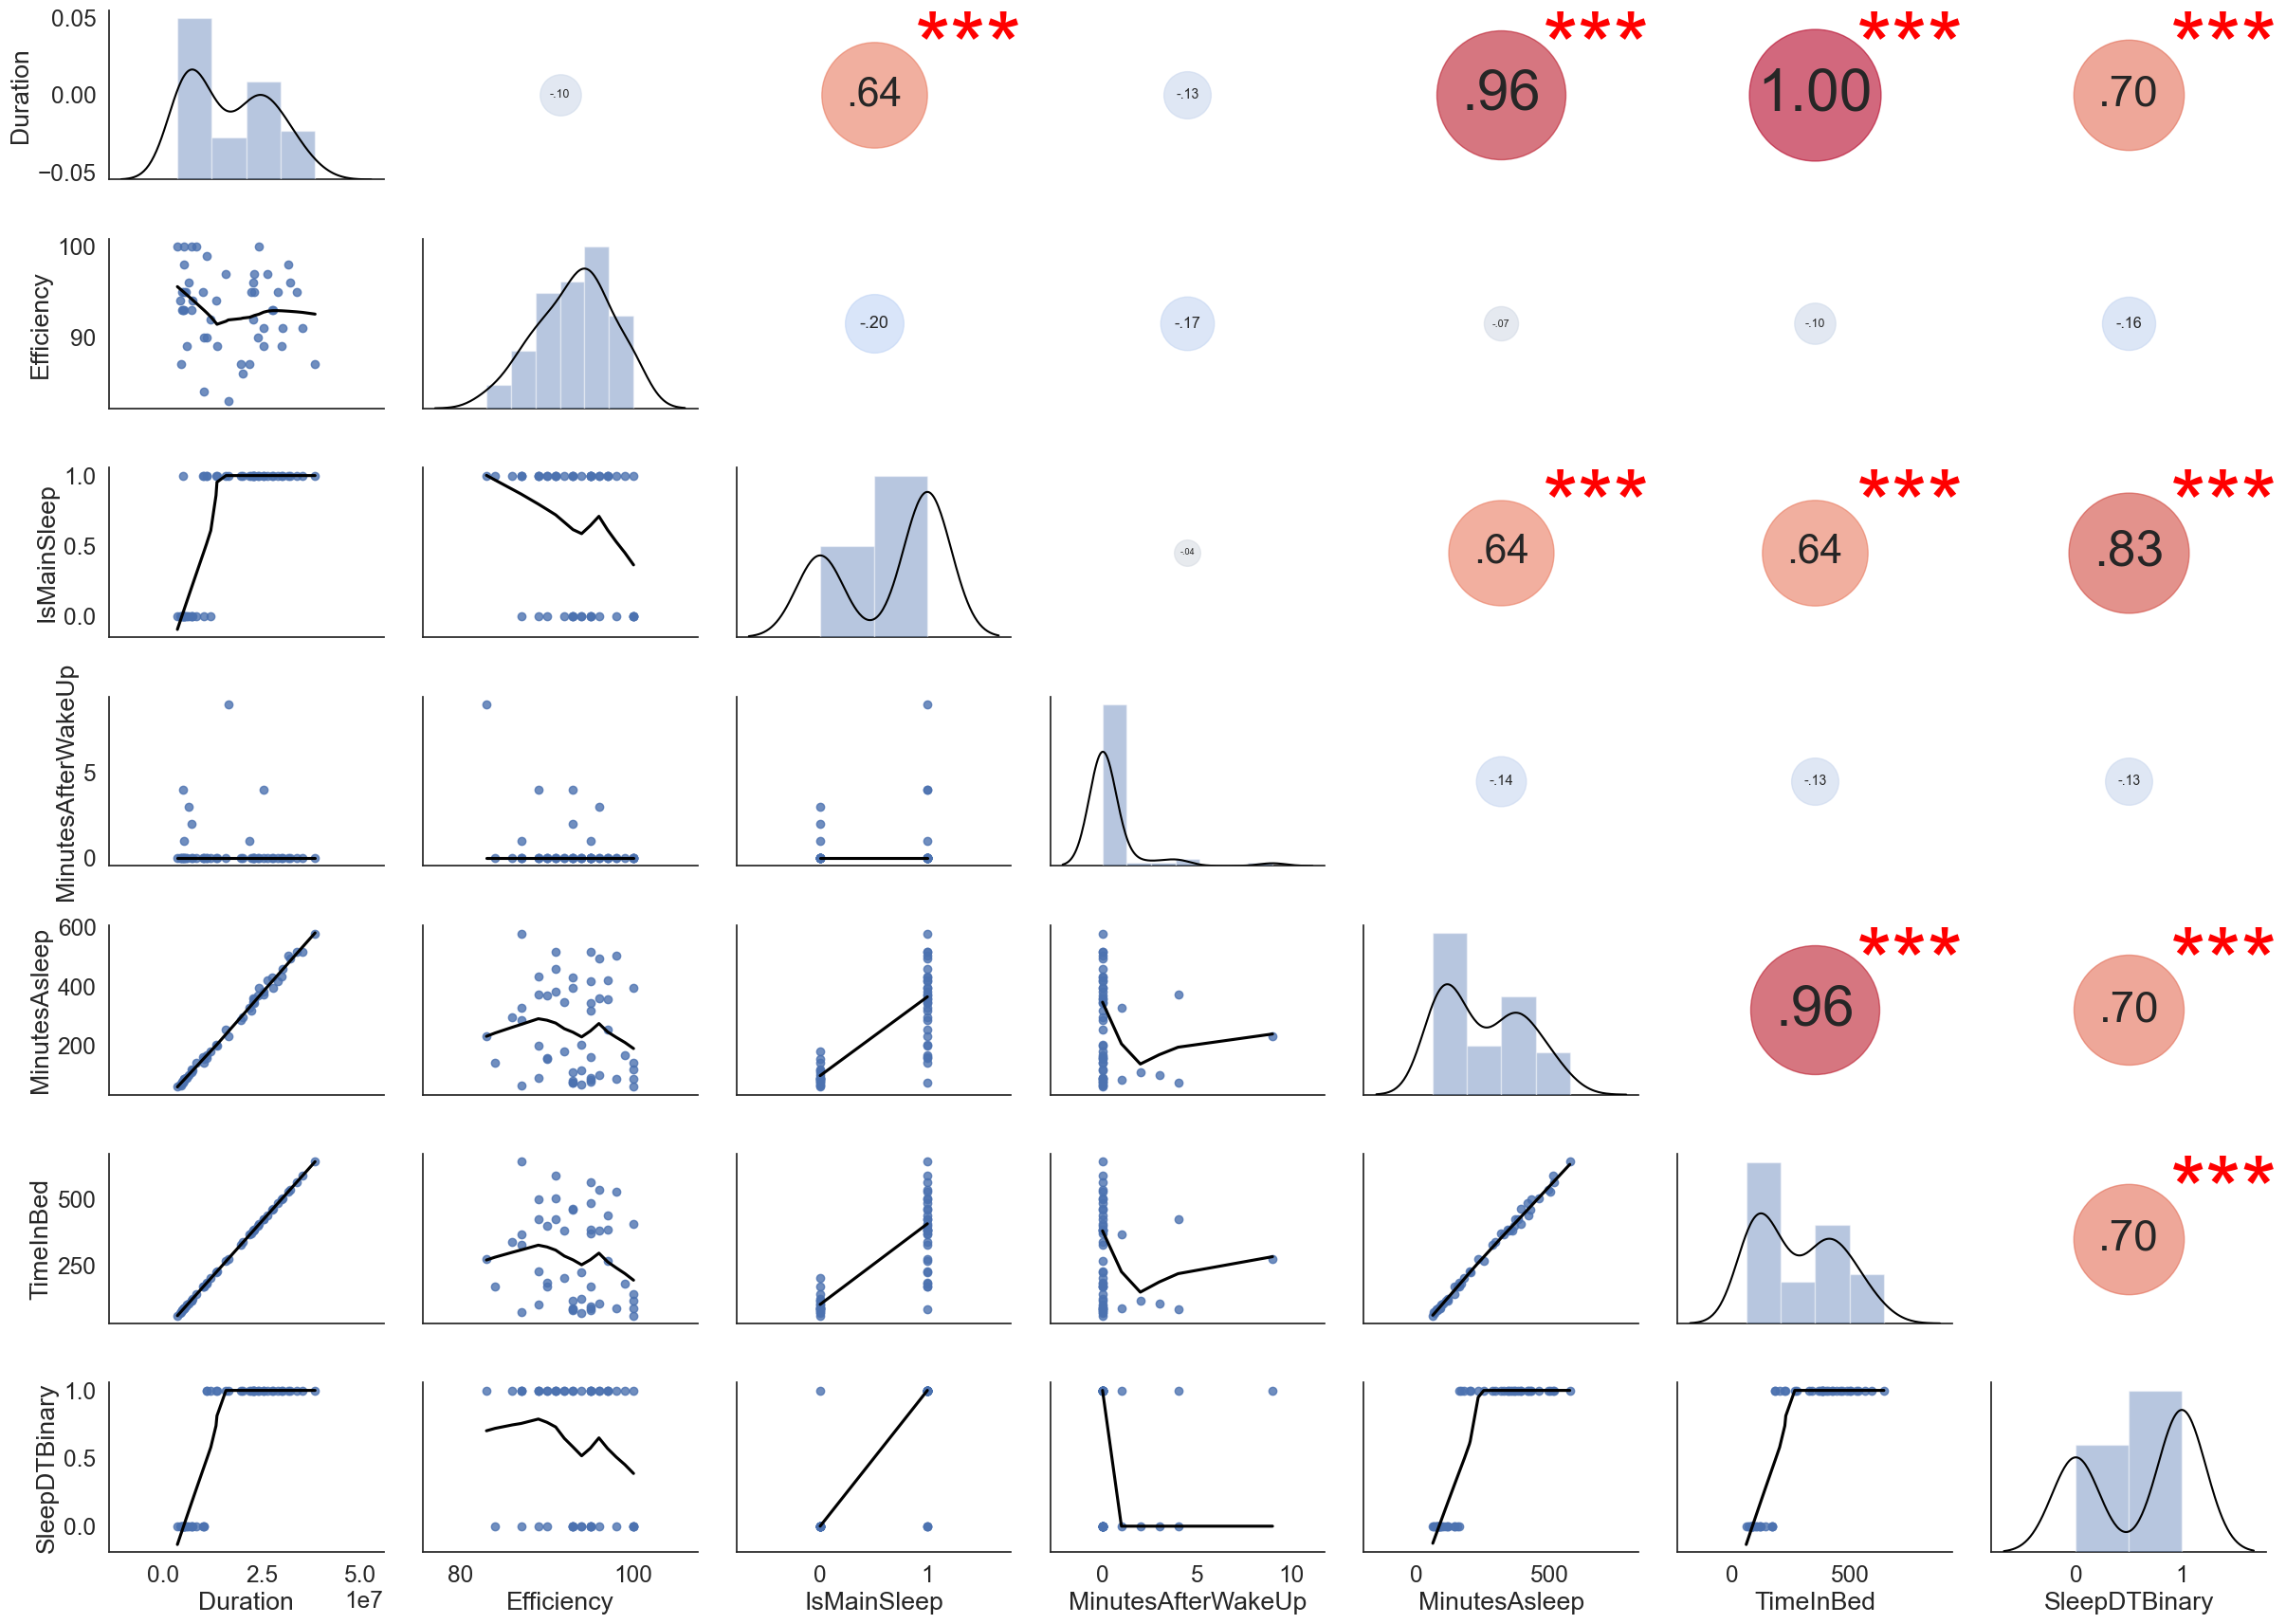

In [26]:
# let's see how well pairwise combinations of general features correlate with each other
pt_sleep_wear_scatter_all = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9, 30]]

plotcorr(pt_sleep_wear_scatter_all)

plt.tight_layout()

save_fig((pt_id + "_scatter_plot_all"))

plt.show()

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.

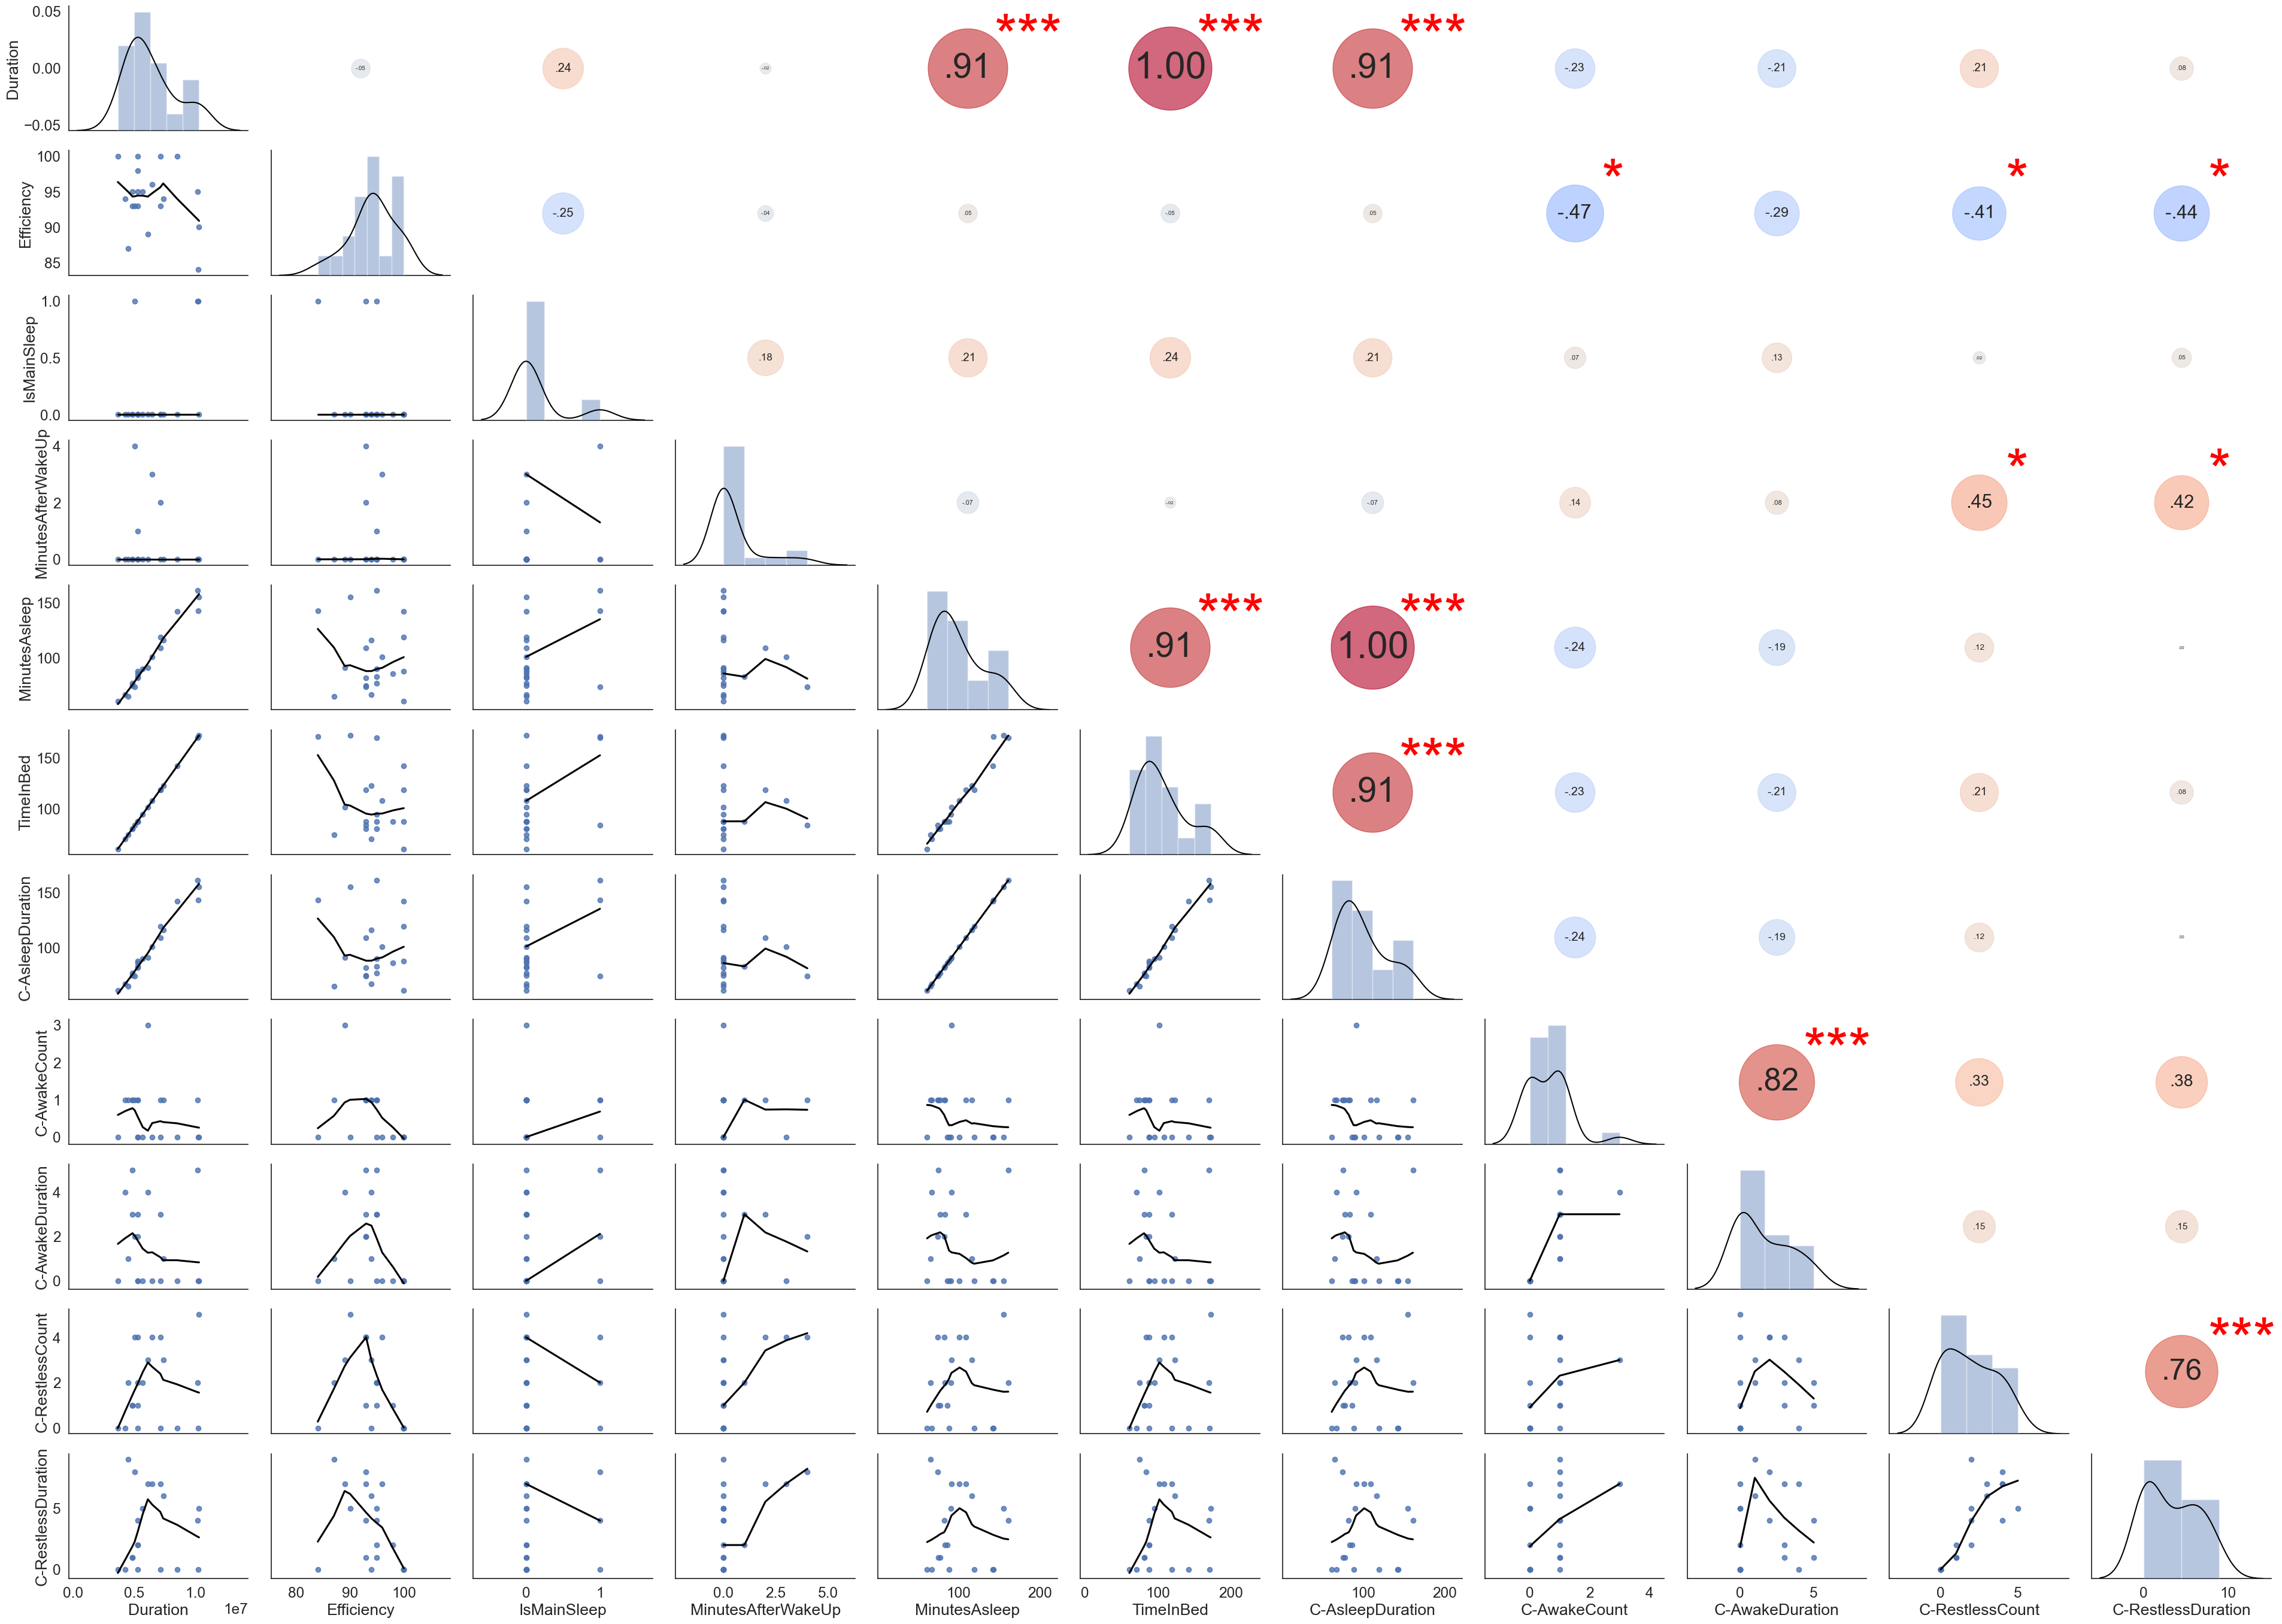

In [27]:
# let's see how well pairwise combinations of classic features correlate with each other
pt_sleep_wear_scatter_classic = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9, 11, 12, 13, 14, 15]].dropna()

plotcorr(pt_sleep_wear_scatter_classic)

plt.tight_layout()

save_fig((pt_id + "_scatter_plot_classic"))

plt.show()

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

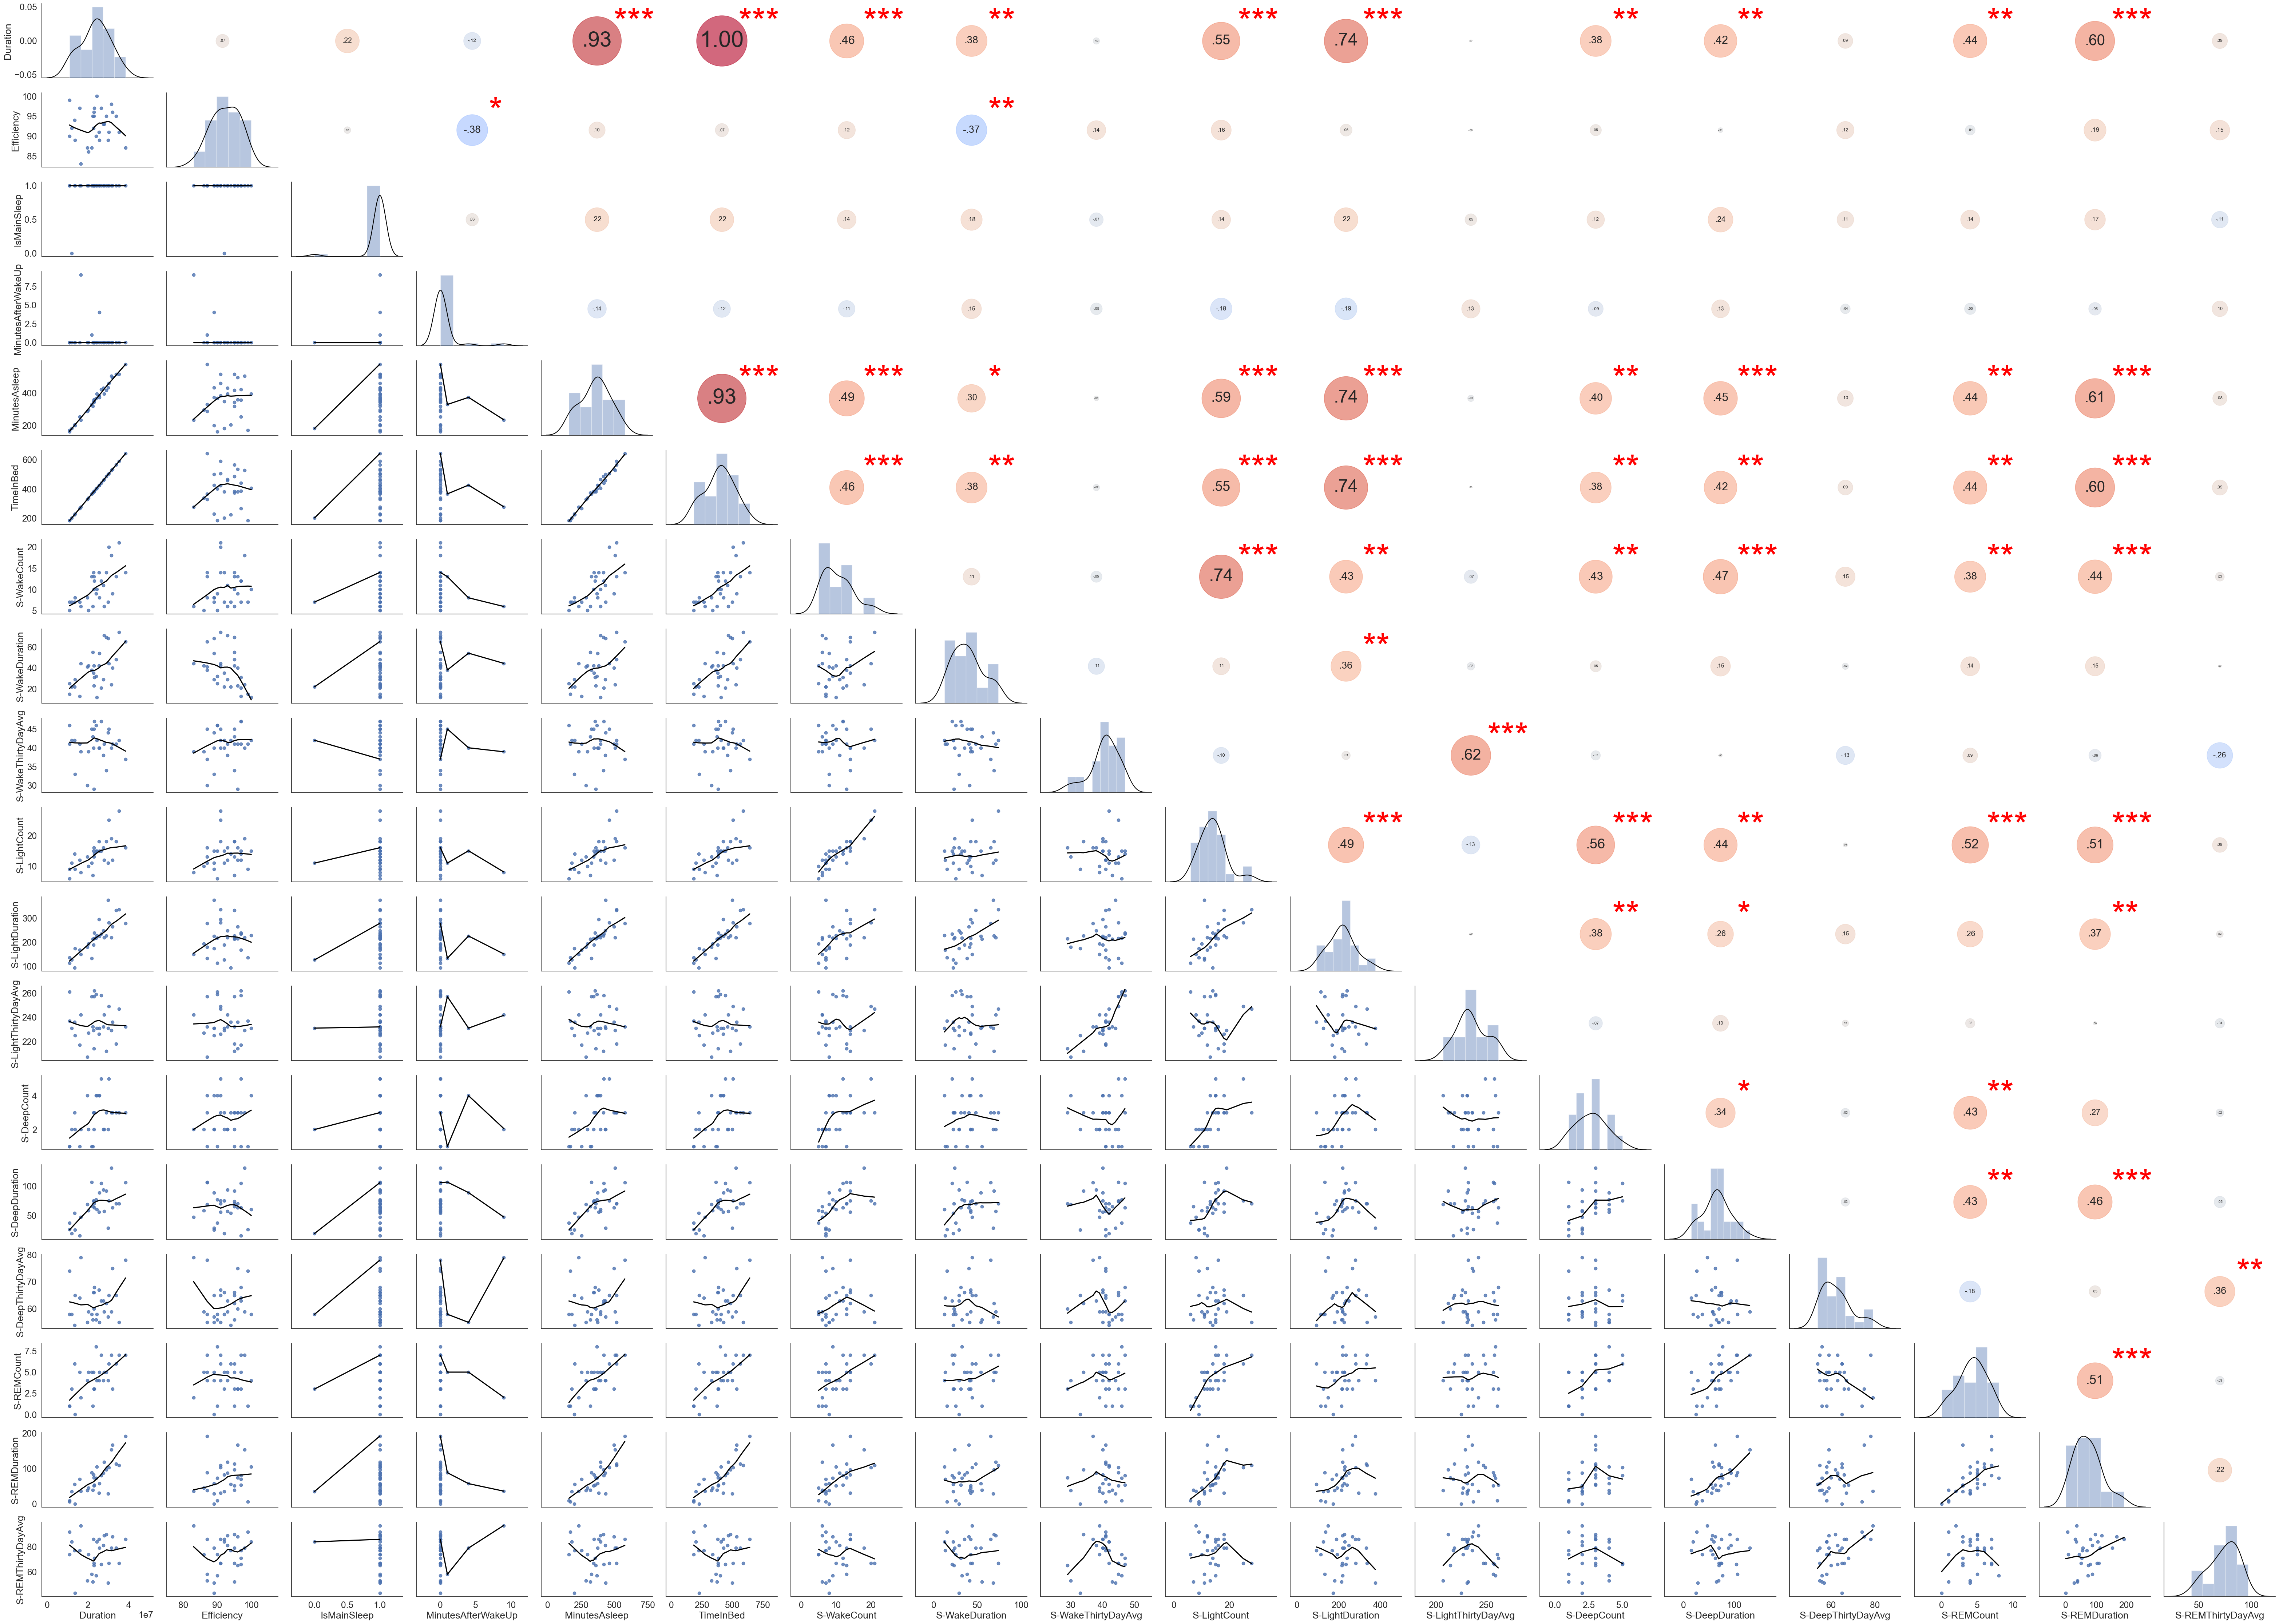

In [28]:
# let's see how well pairwise combinations of stages features correlate with each other
pt_sleep_wear_scatter_stages = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]].dropna()

plotcorr(pt_sleep_wear_scatter_stages)

plt.tight_layout()

save_fig((pt_id + "_scatter_plot_stages"))

plt.show()

In [29]:
# let's see if we can use general features to separate the data into high sleep and low sleep
pt_sleep_wear_scatter_clustered = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9]]

# let's Z score each column across all the instances in our dataset to deal with outliers better
pt_sleep_wear_scatter_clustered = pd.DataFrame(StandardScaler().fit_transform(pt_sleep_wear_scatter_clustered), columns = pt_sleep_wear_scatter_clustered.columns)

# we will use a hierarchical clustering algorithm (hierarchical DBSCAN)
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(pt_sleep_wear_scatter_clustered)

pt_sleep_wear_scatter_clustered["cluster"] = cluster_labels.tolist()

In [30]:
# let's see the first 5 rows of the clustering results
pt_sleep_wear_scatter_clustered.head()

Duration  Efficiency  IsMainSleep  MinutesAfterWakeUp  MinutesAsleep  \
0 -1.006239    0.662539    -1.333333            1.651049      -0.994855   
1 -1.123326   -0.037326    -1.333333           -0.314485      -1.118674   
2 -1.199432   -1.437057    -1.333333           -0.314485      -1.229460   
3  2.119964   -1.437057     0.750000           -0.314485       2.107143   
4 -0.022715   -2.370212     0.750000            5.582117      -0.141154   

   TimeInBed  cluster  
0  -1.006239       -1  
1  -1.123326        0  
2  -1.199432        0  
3   2.119964       -1  
4  -0.022715       -1

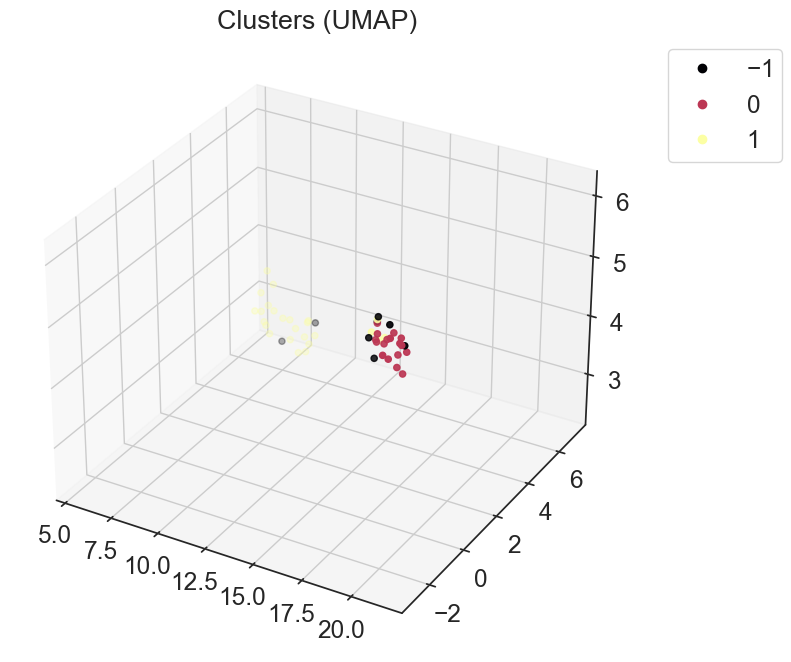

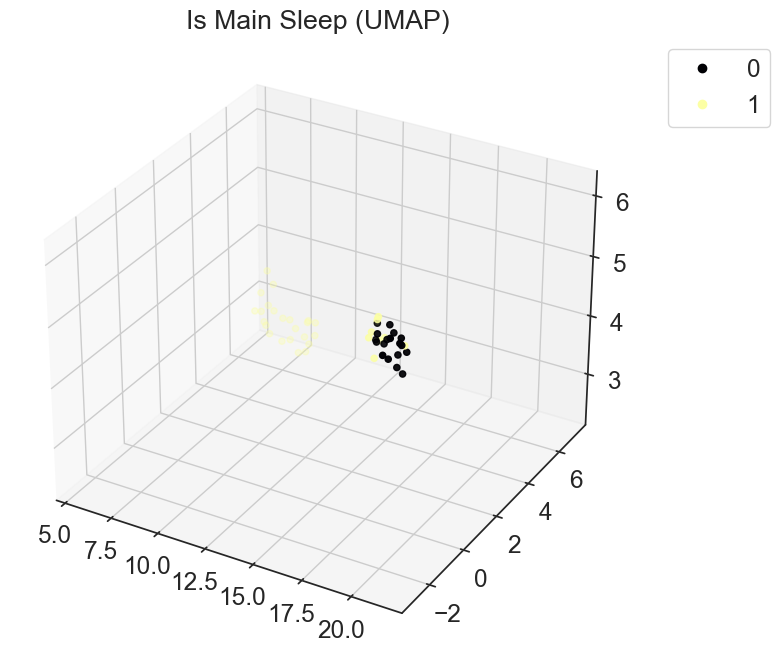

In [31]:
# let's visualize clusters and IsMainSleep in 3D using UMAP for nonlinear dimensionality reduction
pt_sleep_wear_scatter = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9]]

umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_3d = umap_3d.fit_transform(pt_sleep_wear_scatter)

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
sc = ax.scatter3D(proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2], c=pt_sleep_wear_scatter_clustered["cluster"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Clusters (UMAP)")

save_fig((pt_id + "_clusters_umap"))

# show plot
plt.show()

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
sc = ax.scatter3D(proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2], c=pt_sleep_wear["IsMainSleep"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Is Main Sleep (UMAP)")

save_fig((pt_id + "_is_main_sleep_umap"))

# show plot
plt.show()

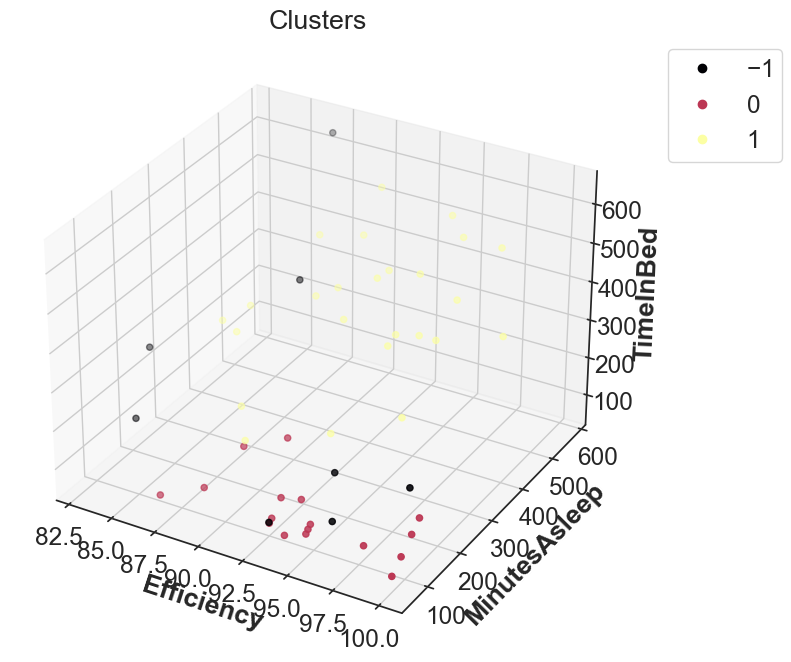

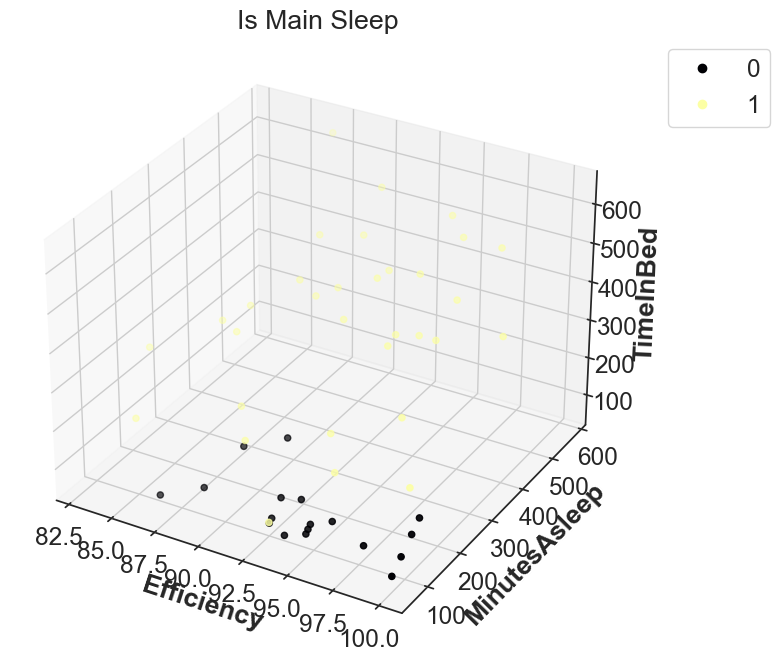

In [32]:
# let's visualize the clustering results in a 3D scatter plot with more concrete axes
pt_sleep_wear_scatter = pt_sleep_wear.iloc[:, [3, 7, 9]].to_numpy()

# Creating figure
fig = plt.figure(figsize = (10, 7))
plt.axes(projection='3d')
ax = fig.gca()

# Creating plot
sc = ax.scatter3D(pt_sleep_wear_scatter[:, 0], pt_sleep_wear_scatter[:, 1], pt_sleep_wear_scatter[:, 2], c=pt_sleep_wear_scatter_clustered["cluster"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Clusters")

ax.set_xlabel(pt_sleep_wear.columns[3], fontweight ='bold')
ax.set_ylabel(pt_sleep_wear.columns[7], fontweight ='bold')
ax.set_zlabel(pt_sleep_wear.columns[9], fontweight ='bold')

save_fig((pt_id + "_clusters_3D_efficiency"))

# show plot
plt.show()

# Creating figure
fig = plt.figure(figsize = (10, 7))
plt.axes(projection='3d')
ax = fig.gca()

# Creating plot
sc = ax.scatter3D(pt_sleep_wear_scatter[:, 0], pt_sleep_wear_scatter[:, 1], pt_sleep_wear_scatter[:, 2], c=pt_sleep_wear["IsMainSleep"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Is Main Sleep")

ax.set_xlabel(pt_sleep_wear.columns[3], fontweight ='bold')
ax.set_ylabel(pt_sleep_wear.columns[7], fontweight ='bold')
ax.set_zlabel(pt_sleep_wear.columns[9], fontweight ='bold')

save_fig((pt_id + "_is_main_sleep_3D_efficiency"))

# show plot
plt.show()

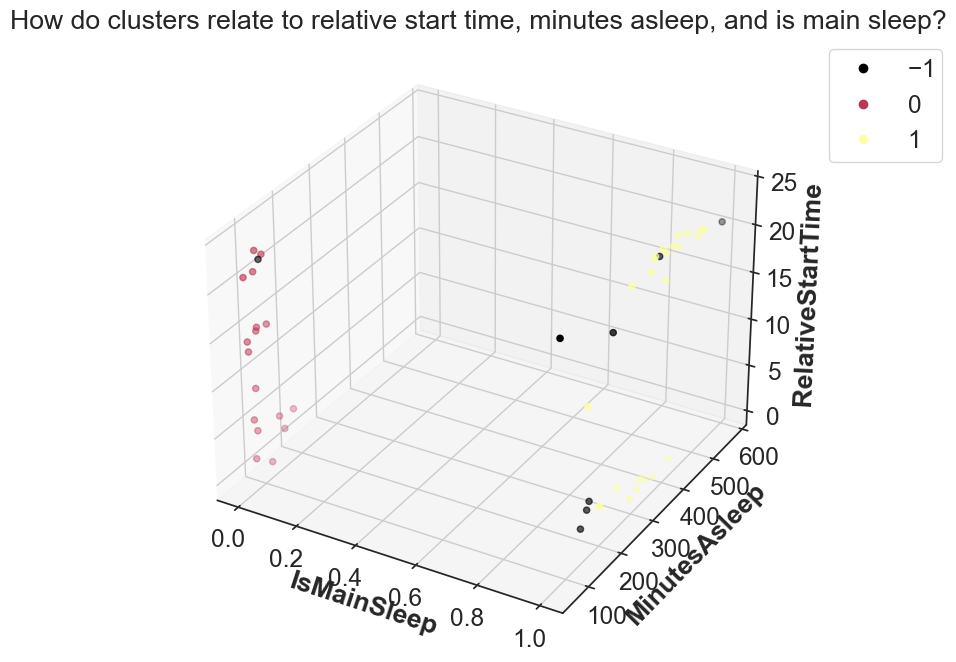

In [33]:
# How do clusters relate to relative start time, minutes asleep, and is main sleep?
pt_sleep_wear_scatter = pt_sleep_wear.iloc[:, [4, 7, 31]].to_numpy()

# Creating figure
fig = plt.figure(figsize = (10, 7))
plt.axes(projection='3d')
ax = fig.gca()

# Creating plot
sc = ax.scatter3D(pt_sleep_wear_scatter[:, 0], pt_sleep_wear_scatter[:, 1], pt_sleep_wear_scatter[:, 2], c=pt_sleep_wear_scatter_clustered["cluster"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("How do clusters relate to relative start time, minutes asleep, and is main sleep?")

ax.set_xlabel(pt_sleep_wear.columns[4], fontweight ='bold')
ax.set_ylabel(pt_sleep_wear.columns[7], fontweight ='bold')
ax.set_zlabel(pt_sleep_wear.columns[31], fontweight ='bold')

save_fig((pt_id + "_clusters_3D_relative_start_time"))

plt.show()

In [34]:
# let's calculate cluster fingerprints to see 
# if the clusters actually represent high and low sleep based on objective metrics
minClusterIndex = 0
maxClusterIndex = pt_sleep_wear_scatter_clustered["cluster"].max()

clusterFingerPrintsMeanZScore = pd.DataFrame()
clusterFingerPrintsStdZScore = pd.DataFrame()

for i in range(maxClusterIndex + 1):
    rowsOfInterest = pt_sleep_wear_scatter_clustered[pt_sleep_wear_scatter_clustered["cluster"] == i]
    
    clusterFingerPrintsMeanZScore["Cluster " + str(i)] = rowsOfInterest.loc[:, rowsOfInterest.columns != "cluster"].mean(axis=0)
    clusterFingerPrintsStdZScore["Cluster " + str(i)] = rowsOfInterest.loc[:, rowsOfInterest.columns != "cluster"].std(axis=0)

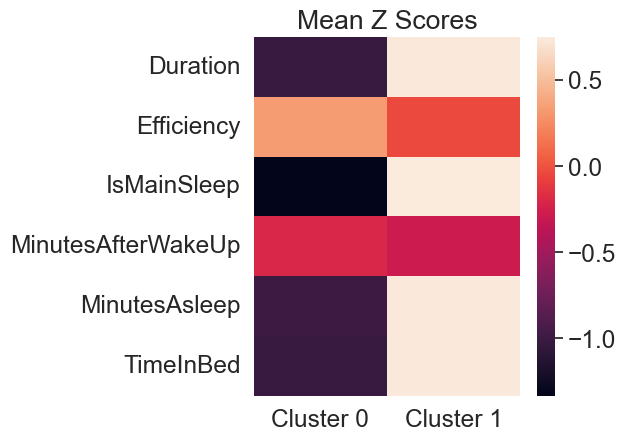

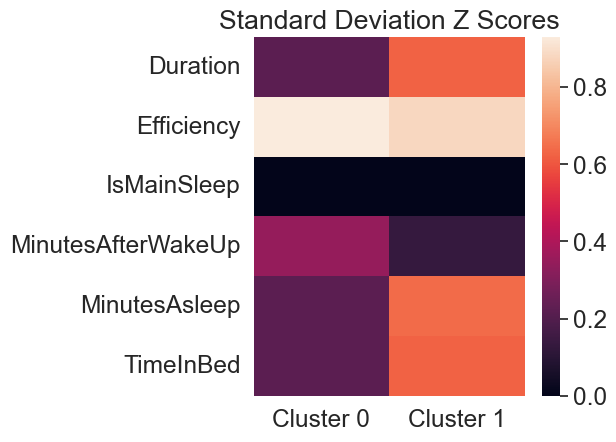

In [35]:
# plotting correlation heatmap
sns.heatmap(clusterFingerPrintsMeanZScore).set(title="Mean Z Scores")

save_fig((pt_id + "_cluster_fingerprints_mean_z_score"))

plt.show() 

sns.heatmap(clusterFingerPrintsStdZScore).set(title="Standard Deviation Z Scores")  

save_fig((pt_id + "_cluster_fingerprints_std_z_score"))

plt.show()